# Project Title: Evaluating Dimensionality Reduction for High-Dimensional Image Classification

## Setup & Data Loading

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cudf
import cuml
import cupy as cp
import pandas as pd

SEED = 17
THRESHOLD = 0.9

In [237]:
df_train = cudf.read_csv("fashion-mnist_train.csv")
df_test = cudf.read_csv("fashion-mnist_test.csv")

In [238]:
print(f"Train df has shape of {df_train.shape}")
print(f"Test df has shape of {df_test.shape}")

Train df has shape of (60000, 785)
Test df has shape of (10000, 785)


## Data Preprocessing

In [239]:
X_train_gpu = df_train.drop(columns="label")
y_train_gpu = df_train["label"]

X_test_gpu = df_test.drop(columns="label")
y_test_gpu = df_test["label"]

In [240]:
from cuml.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled_gpu = scaler.fit_transform(X_train_gpu)
X_test_scaled_gpu = scaler.transform(X_test_gpu)

## Part 1: Unsupervised Reduction with PCA

In [241]:
pca = cuml.PCA(n_components=None)
pca.fit(X_train_scaled_gpu)

[2025-08-02 13:28:11.922] [CUML] [warning] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


PCA()

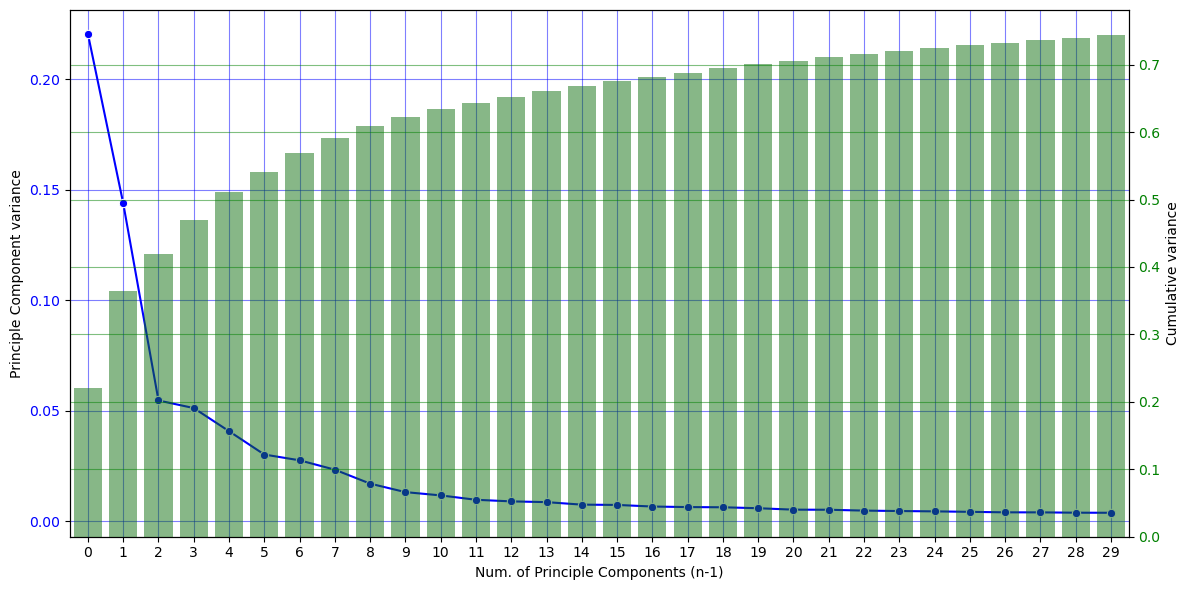

In [242]:
cum_variance_gpu = cp.cumsum(pca.explained_variance_ratio_.values)
pca_variance_gpu = pca.explained_variance_ratio_

df_pca_gpu = cudf.DataFrame(
    data={
        "Cumulative Variance": cum_variance_gpu,
        "Principle Component Variance": pca_variance_gpu,
    }
)
df_pca_cpu = df_pca_gpu.to_pandas()

num_components_to_plot = 30
fig, ax1 = plt.subplots(figsize=(12, 6))
line_color = "blue"
bar_color = "green"
sns.lineplot(
    data=df_pca_cpu["Principle Component Variance"][:num_components_to_plot],
    marker="o",
    ax=ax1,
    color=line_color,
)
ax2 = ax1.twinx()
sns.barplot(
    data=df_pca_cpu["Cumulative Variance"][:num_components_to_plot],
    alpha=0.5,
    ax=ax2,
    color=bar_color,
)
ax1.set_ylabel("Principle Component variance")
ax1.tick_params(axis="y", labelcolor=line_color)
ax2.tick_params(axis="y", labelcolor=bar_color)
ax2.set_ylabel("Cumulative variance")
ax1.set_xlabel("Num. of Principle Components (n-1)")
ax1.grid(alpha=0.5, color=line_color)
ax2.grid(alpha=0.5, color=bar_color)
plt.tight_layout()

In [243]:
thresh_idx = cp.where(cum_variance_gpu >= THRESHOLD)[0][0].get()
print(
    f"Elbow point at component 3 with cumulative explained variance of {round(df_pca_cpu['Cumulative Variance'][2], 2)}."
)
print(
    f"Component {thresh_idx + 1} above threshold with cumulative explained variance of {round(df_pca_cpu.iloc[thresh_idx]['Cumulative Variance'], 2)}."
)

Elbow point at component 3 with cumulative explained variance of 0.42.
Component 137 above threshold with cumulative explained variance of 0.9.


In [244]:
pca_new = cuml.PCA(n_components=2)
X_train_pca_gpu = pca_new.fit_transform(X_train_scaled_gpu)
X_test_pca_gpu = pca_new.transform(X_test_scaled_gpu)

In [245]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_decision_boundary(X, y, classifier, random_state, n=None):
    total_n = len(X)
    rng = np.random.default_rng(seed=random_state)
    rand_idx = rng.choice(total_n, min(n, total_n), replace=False)
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[0].min(), X[0].max()), np.linspace(X[1].min(), X[1].max())
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(classifier.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)

    display.plot()
    display.ax_.scatter(
        X[0].to_numpy()[rand_idx],
        X[1].to_numpy()[rand_idx],
        c=y.to_numpy()[rand_idx],
        edgecolor="black",
        alpha=0.7,
        s=40,
    )

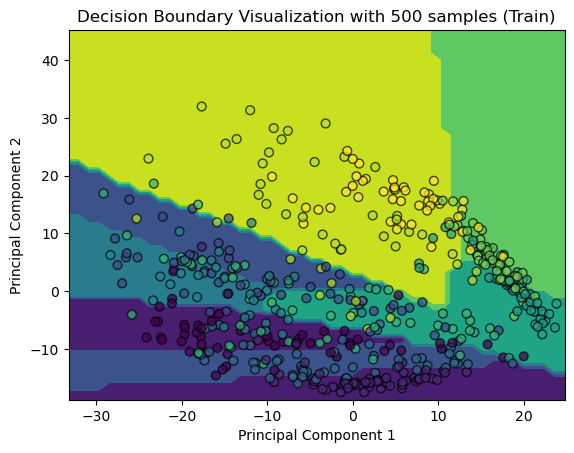

In [246]:
lr_pca = cuml.LogisticRegression().fit(X_train_pca_gpu, y_train_gpu)
n_samples = 500
plot_decision_boundary(
    X=X_train_pca_gpu, y=y_train_gpu, classifier=lr_pca, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Train)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

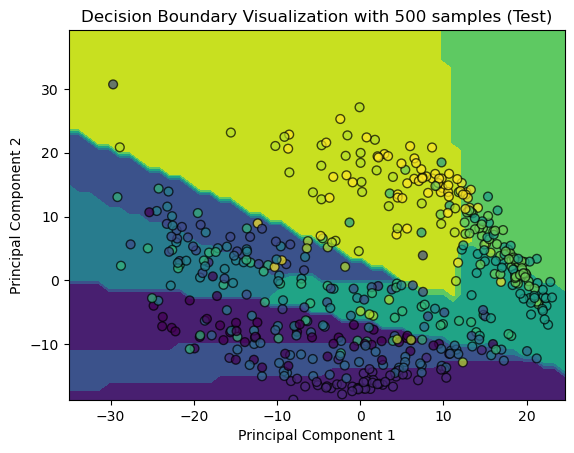

In [247]:
n_samples = 500
plot_decision_boundary(
    X=X_test_pca_gpu, y=y_test_gpu, classifier=lr_pca, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Test)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Part 2: Supervised Reduction with LDA

In [248]:
X_train_scaled_cpu = X_train_scaled_gpu.to_numpy()
X_test_scaled_cpu = X_test_scaled_gpu.to_numpy()
y_train_cpu = y_train_gpu.to_numpy()
y_test_cpu = y_test_gpu.to_numpy()

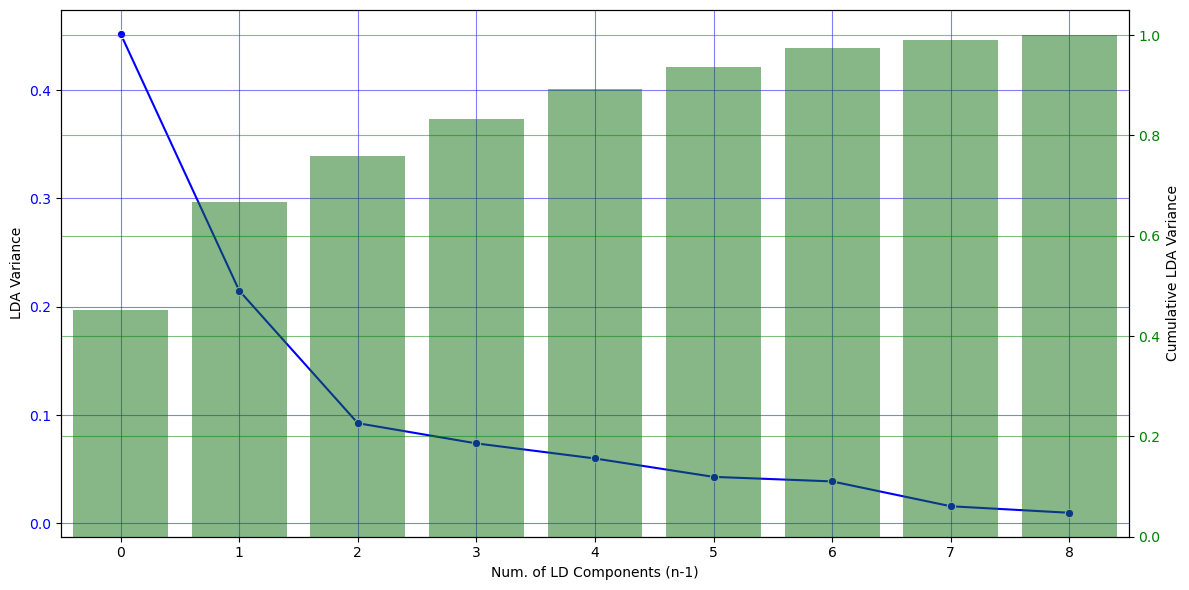

In [249]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=None)
lda.fit(X=X_train_scaled_cpu, y=y_train_cpu)

lda_variance_cpu = lda.explained_variance_ratio_
lda_cum_variance_cpu = np.cumsum(lda_variance_cpu)

df_lda_cpu = pd.DataFrame(
    data={
        "Cumulative LDA Variance": lda_cum_variance_cpu,
        "LDA Variance": lda_variance_cpu,
    }
)

fig, ax1 = plt.subplots(figsize=(12, 6))
line_color = "blue"
bar_color = "green"
sns.lineplot(
    data=df_lda_cpu["LDA Variance"][:num_components_to_plot],
    marker="o",
    ax=ax1,
    color=line_color,
)
ax2 = ax1.twinx()
sns.barplot(
    data=df_lda_cpu["Cumulative LDA Variance"][:num_components_to_plot],
    alpha=0.5,
    ax=ax2,
    color=bar_color,
)
ax1.set_ylabel("LDA Variance")
ax1.tick_params(axis="y", labelcolor=line_color)
ax2.tick_params(axis="y", labelcolor=bar_color)
ax2.set_ylabel("Cumulative LDA Variance")
ax1.set_xlabel("Num. of LD Components (n-1)")
ax1.grid(alpha=0.5, color=line_color)
ax2.grid(alpha=0.5, color=bar_color)
plt.tight_layout()

In [250]:
thresh_idx = np.where(lda_cum_variance_cpu >= THRESHOLD)[0][0]
print(
    f"Elbow point at component 3 with cumulative explained variance of {round(df_lda_cpu['Cumulative LDA Variance'][2], 2)}."
)
print(
    f"Component {thresh_idx + 1} above threshold with cumulative explained variance of {round(df_lda_cpu.iloc[thresh_idx]['Cumulative LDA Variance'], 2)}."
)

Elbow point at component 3 with cumulative explained variance of 0.76.
Component 6 above threshold with cumulative explained variance of 0.94.


In [251]:
lda_new = LDA(n_components=2)
X_train_lda_cpu = lda_new.fit_transform(X=X_train_scaled_cpu, y=y_train_cpu)
X_test_lda_cpu = lda_new.transform(X_test_scaled_cpu)

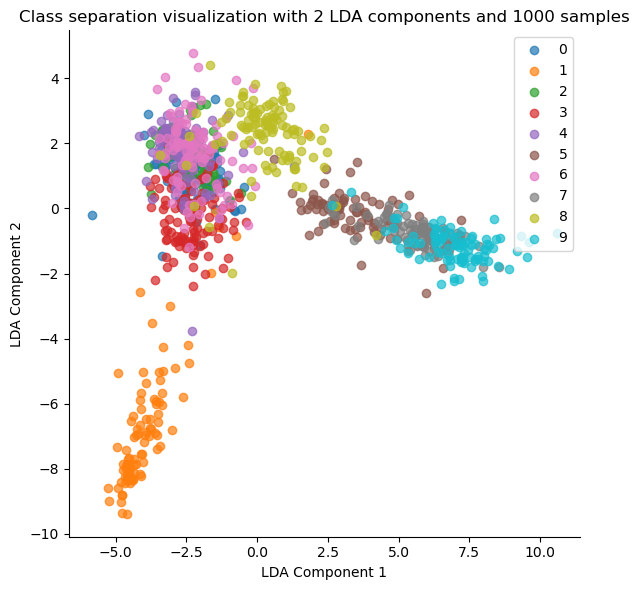

In [252]:
df_lda_new = pd.DataFrame(
    X_train_lda_cpu, columns=["LDA Component 1", "LDA Component 2"]
)
df_lda_new["Class"] = y_train_cpu

n_samples = 1000
total_n = len(df_lda_new)
rng = np.random.default_rng(seed=SEED)
rand_idx = rng.choice(total_n, min(n_samples, total_n), replace=False)
sns.FacetGrid(df_lda_new.iloc[rand_idx], hue="Class", height=6).map(
    plt.scatter, "LDA Component 1", "LDA Component 2", alpha=0.7
)

plt.title(
    f"Class separation visualization with 2 LDA components and {n_samples} samples"
)
plt.legend(loc="upper right")
plt.tight_layout()

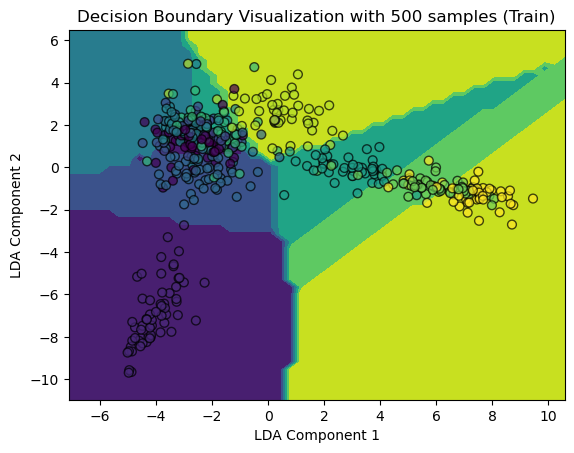

In [253]:
X_train_lda_gpu = cudf.DataFrame(X_train_lda_cpu)

lr_lda = cuml.LogisticRegression().fit(X_train_lda_gpu, y_train_gpu)

n_samples = 500
plot_decision_boundary(
    X=X_train_lda_gpu, y=y_train_gpu, classifier=lr_lda, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Train)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()

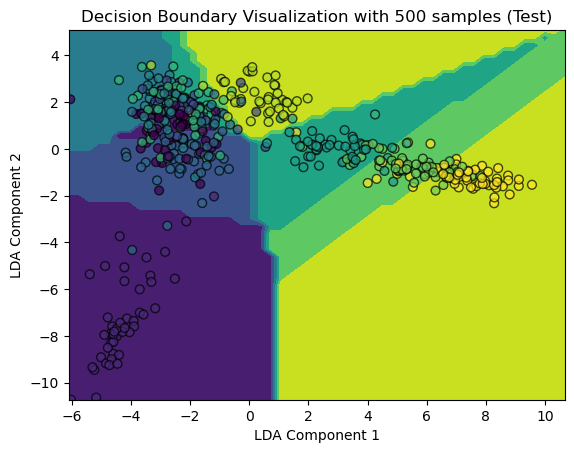

In [254]:
X_test_lda_gpu = cudf.DataFrame(X_test_lda_cpu)

n_samples = 500
plot_decision_boundary(
    X=X_test_lda_gpu, y=y_test_gpu, classifier=lr_lda, n=n_samples, random_state=SEED
)
plt.title(f"Decision Boundary Visualization with {n_samples} samples (Test)")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.show()

## Part 3: Performance Comparison

In [255]:
from cuml.metrics import accuracy_score, confusion_matrix
from cuml import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.svm import LinearSVC


def calc_perf(X_train, X_test, y_train, y_test, classifier: str, max_iter: int = 1000):
    if classifier == "logreg":
        cfr = LogisticRegression(max_iter=max_iter)
    elif classifier == "randfor":
        cfr = RandomForestClassifier(random_state=SEED)
    elif classifier == "svc":
        cfr = LinearSVC(max_iter=max_iter)
    else:
        raise ValueError("Classifier has to be in ['logreg', 'randfor', 'svc']")
    cfr.fit(X_train, y_train)
    y_pred = cfr.predict(X_test)
    acc_score = accuracy_score(y_true=y_test, y_pred=y_pred)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    return acc_score, conf_mat

Getting the accuracy score using logreg with the original (scaled) data

In [256]:
%%time
acc_score_lc_ori, conf_mat_lc_ori = calc_perf(
    X_train=X_train_scaled_gpu,
    X_test=X_test_scaled_gpu,
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="logreg",
    max_iter=4000,
)  # max_iter=4000 as 1000 and 2000 both failed to converge

CPU times: user 34.2 s, sys: 7.24 s, total: 41.4 s
Wall time: 41.4 s


In [257]:
print(
    f"Using logreg on original scaled train dataset has accuracy score of {acc_score_lc_ori}"
)
print(cudf.DataFrame(conf_mat_lc_ori))

Using logreg on original scaled train dataset has accuracy score of 0.8446
     0    1    2    3    4    5    6    7    8    9
0  816    2   20   41    3    3  100    0   15    0
1    2  969    4   16    0    1    7    1    0    0
2   21    6  750   13  111    0   91    0    8    0
3   33   28   16  851   29    1   28    2   11    1
4    1    2   80   32  798    2   78    0    7    0
5    2    4    0    0    0  902    0   57    8   27
6  151    5  106   40   89    0  591    0   17    1
7    0    0    0    0    1   33    0  920    2   44
8    9    2    7   12    4   13   26    6  918    3
9    1    0    0    0    0   16    0   51    1  931


It seems that using logreg with just the scaled data produces good accuracy scores for classes 1, 7, 8, and 9. Class 6 is problematic and gets confused frequently with classes 0 and 2.

Now let's try the same thing but with the PCA-reduced data with 3 (elbow) and 137 (90% cumulative variance) components.

In [258]:
%%time
pca_3 = cuml.PCA(n_components=3)
X_train_pca3_gpu = pca_3.fit_transform(X_train_scaled_gpu)
X_test_pca3_gpu = pca_3.transform(X_test_scaled_gpu)
acc_score_lc_pca3, conf_mat_lc_pca3 = calc_perf(
    X_train=X_train_pca3_gpu,
    X_test=X_test_pca3_gpu,
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 948 ms, sys: 91.9 ms, total: 1.04 s
Wall time: 1.05 s


In [259]:
%%time
pca_137 = cuml.PCA(n_components=137)
X_train_pca137_gpu = pca_137.fit_transform(X_train_scaled_gpu)
X_test_pca137_gpu = pca_137.transform(X_test_scaled_gpu)
acc_score_lc_pca137, conf_mat_lc_pca137 = calc_perf(
    X_train=X_train_pca137_gpu,
    X_test=X_test_pca137_gpu,
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 9.78 s, sys: 1.92 s, total: 11.7 s
Wall time: 11.7 s


In [260]:
print(
    f"Using logreg on PCA scaled data with 3 components has an accuracy score of {acc_score_lc_pca3}."
)
print(cudf.DataFrame(conf_mat_lc_pca3))
print(
    f"\n\nUsing logreg on PCA scaled data with 137 components has an accuracy score of {acc_score_lc_pca137}."
)
print(cudf.DataFrame(conf_mat_lc_pca137))

Using logreg on PCA scaled data with 3 components has an accuracy score of 0.6076.
     0    1    2    3    4    5    6    7    8    9
0  672   17   18  111   71   18   62    0   30    1
1   26  887   18   59    2    1    5    0    1    1
2   43    2  621    5  178    3  113    0   35    0
3  124  238    6  594   11    5   16    0    1    5
4  140    3  443   80  242    3   72    0   17    0
5    0    0    1    3    0  687    5  213   38   53
6  233    5  278   60  162    5  203    0   54    0
7    0    0    0    0    0  238    0  649    0  113
8    1    5   29   34   17   49   95    2  742   26
9    0    0    0    0    0   10    1  151   59  779


Using logreg on PCA scaled data with 137 components has an accuracy score of 0.8542.
     0    1    2    3    4    5    6    7    8    9
0  814    4   16   46    1    2  104    0   13    0
1    0  968    6   18    0    2    5    1    0    0
2   11    3  765   12  116    0   82    0   11    0
3   32   21   15  885   22    1   22    1    1    

As expected, using only 3 components with a cumulative variance of only 0.42 produced a poor accuracy score of 0.6075. On the other hand, PCA with 137 components had a much better accuracy score of 0.854 while taking 3 times faster to process. It performed exceptionally well for classes 1, 5, 7, 8, 9. On the other hand, it performed just as bad when classifing class 6, confusing it with classes 0 and 2.

Now let's try the same thing but with the LDA-reduced data with 3 (elbow) and 6 (94% cumulative variance) components.

In [261]:
%%time
lda_3 = LDA(n_components=3)
X_train_lda3_cpu = lda_3.fit_transform(X=X_train_scaled_cpu, y=y_train_cpu)
X_test_lda3_cpu = lda_3.transform(X_test_scaled_cpu)
acc_score_lc_lda3, conf_mat_lc_lda3 = calc_perf(
    X_train=cp.asarray(X_train_lda3_cpu),
    X_test=cp.asarray(X_test_lda3_cpu),
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 9.72 s, sys: 792 ms, total: 10.5 s
Wall time: 3.3 s


In [262]:
%%time
lda_6 = LDA(n_components=6)
X_train_lda6_cpu = lda_6.fit_transform(X=X_train_scaled_cpu, y=y_train_cpu)
X_test_lda6_cpu = lda_6.transform(X_test_scaled_cpu)
acc_score_lc_lda6, conf_mat_lc_lda6 = calc_perf(
    X_train=cp.asarray(X_train_lda6_cpu),
    X_test=cp.asarray(X_test_lda6_cpu),
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="logreg",
    max_iter=4000,
)

CPU times: user 9.72 s, sys: 486 ms, total: 10.2 s
Wall time: 3.09 s


In [263]:
print(
    f"Using logreg on LDA scaled data with 3 components has an accuracy score of {acc_score_lc_lda3}."
)
print(cudf.DataFrame(conf_mat_lc_lda3))
print(
    f"\n\nUsing logreg on LDA scaled data with 6 components has an accuracy score of {acc_score_lc_lda6}."
)
print(cudf.DataFrame(conf_mat_lc_lda6))

Using logreg on LDA scaled data with 3 components has an accuracy score of 0.6659.
     0    1    2    3    4    5    6    7    8    9
0  550    0   34  187  105    2  103    1   18    0
1    0  961    0   32    3    0    3    1    0    0
2  132    0  131   54  398    1  273    0   11    0
3  137   14   28  705   43    1   71    0    1    0
4   65    1   71   74  603    2  180    0    4    0
5    0    0    0    1    1  792    0  146   16   44
6  190    0   58  112  237    2  376    0   25    0
7    0    0    0    0    0  154    0  749    1   96
8    3    0    5    5   18   25   12    8  924    0
9    0    0    0    0    0   53    0   79    0  868


Using logreg on LDA scaled data with 6 components has an accuracy score of 0.778.
     0    1    2    3    4    5    6    7    8    9
0  811    2    8   62    4    2   94    0   17    0
1    1  971    8   16    0    0    3    1    0    0
2   17    1  504   11  264    1  190    0   12    0
3   36   14   14  869   22    2   42    0    1    0
4

Unsurprisingly, LDA with 6 components produced a better accuracy score compared to 3 components. The individual class accuracies are very similar and consistent with the previous methods.

## Part 4: Nonlinear Visualization with t-SNE

In [264]:
from cuml import TSNE

tsne = TSNE(n_components=2, random_state=SEED)
X_train_tsne = tsne.fit_transform(X=X_train_scaled_gpu, y=y_train_gpu)
print(f"TSNE transformed dataset has shape {X_train_tsne.shape}.")

[2025-08-02 13:29:20.662] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
TSNE transformed dataset has shape (60000, 2).


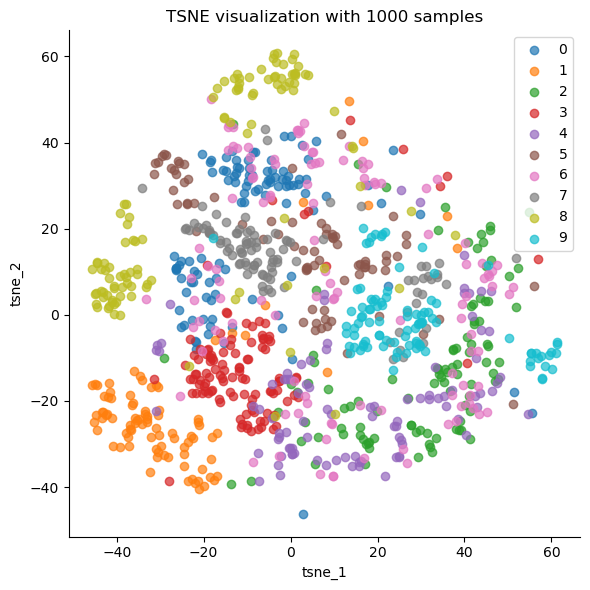

In [265]:
df_tsne_gpu = cudf.DataFrame(
    data={"tsne_1": X_train_tsne[0], "tsne_2": X_train_tsne[1], "class": y_train_gpu}
)
df_tsne_cpu = df_tsne_gpu.to_pandas()

n_samples = 1000
total_n = len(df_tsne_cpu)
rng = np.random.default_rng(seed=SEED)
rand_idx = rng.choice(total_n, min(n_samples, total_n), replace=False)
sns.FacetGrid(df_tsne_cpu.iloc[rand_idx], hue="class", height=6).map(
    plt.scatter, "tsne_1", "tsne_2", alpha=0.7
)

plt.title(f"TSNE visualization with {n_samples} samples")
plt.legend(loc="upper right")
plt.tight_layout()

## Part 5: Trying out other classifiers (Random Forest Classifier and SVC).

RFC

In [266]:
%%time
acc_score_rfc_pca3, conf_mat_rfc_pca3 = calc_perf(
    X_train=X_train_pca3_gpu,
    X_test=X_test_pca3_gpu,
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="randfor",
)

CPU times: user 4.27 s, sys: 1.05 s, total: 5.32 s
Wall time: 2.15 s


In [267]:
%%time
acc_score_rfc_pca137, conf_mat_rfc_pca137 = calc_perf(
    X_train=X_train_pca137_gpu,
    X_test=X_test_pca137_gpu,
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="randfor",
)

CPU times: user 4.44 s, sys: 1.67 s, total: 6.11 s
Wall time: 1.66 s


In [268]:
%%time
acc_score_rfc_lda3, conf_mat_rfc_lda3 = calc_perf(
    X_train=cp.asarray(X_train_lda3_cpu),
    X_test=cp.asarray(X_test_lda3_cpu),
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="randfor",
)

CPU times: user 3.58 s, sys: 908 ms, total: 4.49 s
Wall time: 1.12 s


In [269]:
%%time
acc_score_rfc_lda6, conf_mat_rfc_lda6 = calc_perf(
    X_train=cp.asarray(X_train_lda6_cpu),
    X_test=cp.asarray(X_test_lda6_cpu),
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="randfor",
)

CPU times: user 3.65 s, sys: 1.1 s, total: 4.75 s
Wall time: 1.18 s


In [281]:
print(f"Random forest classifier has the following accuracy scores: \nPCA with 3 components - {acc_score_rfc_pca3}, \nPCA with 137 components - {acc_score_rfc_pca137}, \nLDA with 3 components - {acc_score_rfc_lda3}, \nLDA with 6 components - {acc_score_rfc_lda6}")

Random forest classifier has the following accuracy scores: 
PCA with 3 components - 0.571, 
PCA with 137 components - 0.8603, 
LDA with 3 components - 0.5842, 
LDA with 6 components - 0.7816


In [285]:
print(f"Confusion matrix of random forest classifier with best performing PCA reduced dataset: \n{cudf.DataFrame(conf_mat_rfc_pca137)}")

Confusion matrix of random forest classifier with best performing PCA reduced dataset: 
     0    1    2    3    4    5    6    7    8    9
0  839    1   12   46    5    3   74    1   18    1
1    4  963    5   22    0    2    3    0    1    0
2    8    0  772   12  131    3   63    0   11    0
3   21    6   10  912   31    3   16    0    1    0
4    0    0   57   27  855    1   52    0    8    0
5    0    0    1    1    0  901    0   54    5   38
6  183    0  108   29   84    4  564    0   28    0
7    0    0    0    0    0   46    0  882    1   71
8    1    0    8    4    1    3    7    2  974    0
9    0    0    0    0    0   20    0   39    0  941


Random forest classifier applied on a PCA reduced dataset with 137 components produced slightly better results compared to logreg on the same dataset, but RFC was much faster (1.66s vs 11.7s).

Linear SVC

In [288]:
%%time
acc_score_svc_pca3, conf_mat_svc_pca3 = calc_perf(
    X_train=X_train_pca3_gpu,
    X_test=X_test_pca3_gpu,
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="svc",
    max_iter=4000,
)

CPU times: user 158 ms, sys: 40.6 ms, total: 199 ms
Wall time: 208 ms


In [289]:
%%time
acc_score_svc_pca137, conf_mat_svc_pca137 = calc_perf(
    X_train=X_train_pca137_gpu,
    X_test=X_test_pca137_gpu,
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="svc",
    max_iter=4000,
)

CPU times: user 1.06 s, sys: 199 ms, total: 1.26 s
Wall time: 1.26 s


In [290]:
%%time
acc_score_svc_lda3, conf_mat_svc_lda3 = calc_perf(
    X_train=cp.asarray(X_train_lda3_cpu),
    X_test=cp.asarray(X_test_lda3_cpu),
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="svc",
    max_iter=4000,
)

CPU times: user 70.2 ms, sys: 36.2 ms, total: 106 ms
Wall time: 105 ms


In [292]:
%%time
acc_score_svc_lda6, conf_mat_svc_lda6 = calc_perf(
    X_train=cp.asarray(X_train_lda6_cpu),
    X_test=cp.asarray(X_test_lda6_cpu),
    y_train=y_train_gpu,
    y_test=y_test_gpu,
    classifier="svc",
    max_iter=4000,
)

CPU times: user 137 ms, sys: 3.33 ms, total: 140 ms
Wall time: 140 ms


In [293]:
print(f"Linear SVC has the following accuracy scores: \nPCA with 3 components - {acc_score_svc_pca3}, \nPCA with 137 components - {acc_score_svc_pca137}, \nLDA with 3 components - {acc_score_svc_lda3}, \nLDA with 6 components - {acc_score_svc_lda6}")

Linear SVC has the following accuracy scores: 
PCA with 3 components - 0.564, 
PCA with 137 components - 0.8481, 
LDA with 3 components - 0.6111, 
LDA with 6 components - 0.7428


In [294]:
print(f"Confusion matrix of SVC with best performing PCA reduced dataset: \n{cudf.DataFrame(conf_mat_svc_pca137)}")

Confusion matrix of SVC with best performing PCA reduced dataset: 
     0    1    2    3    4    5    6    7    8    9
0  811    1   13   72    2    3   78    1   19    0
1    3  971    3   16    1    2    3    1    0    0
2   14    3  752   12  137    0   69    0   13    0
3   33   20   14  882   26    1   22    1    1    0
4    1    2   71   31  819    1   73    0    2    0
5    2    0    0    1    0  917    0   50   10   20
6  175    4  125   47   88    2  536    0   23    0
7    0    0    0    0    0   43    0  910    1   46
8    5    0    7   12    5    9   15    5  941    1
9    0    0    0    0    0   17    0   40    1  942


SVC applied on a PCA reduced dataset with 137 components produced slightly worse results compared to logreg and RFC on the same dataset, but SVC ran the fastest (1.26s).

## Part 6: Final optimized Pipeline